In [5]:
import numpy as np
def sigmoid(X, weights, bias):
    z = X.dot(weights) + bias
    return 1 / (1 + np.exp(-z))


def gradient_descent_learning(X, y, weights, bias, eta=0.01, n_iter=1000):
    m = X.shape[0]  # Number of samples
    for _ in range(n_iter):
        predictions = sigmoid(X, weights, bias)
        errors = predictions - y
        gd_weights = X.T.dot(errors) / m
        gd_bias = np.sum(errors) / m

        weights -= eta * gd_weights
        bias -= eta * gd_bias

    return weights, bias


def cross_entropy_loss(X, y, weights, bias):
    m = len(y)
    h = sigmoid(X, weights, bias)
    cost = (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h)))
    return cost

In [6]:
import numpy as np

class Conv3D:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size, filter_size) / (filter_size ** 1.5)
        self.bias = np.zeros((num_filters, 1))

    def forward(self, input):
        self.input = input
        self.output = np.zeros((input.shape[0] - self.filter_size + 1,
                                input.shape[1] - self.filter_size + 1,
                                input.shape[2] - self.filter_size + 1,
                                self.num_filters))
        for i in range(self.output.shape[0]):
            for j in range(self.output.shape[1]):
                for k in range(self.output.shape[2]):
                    input_slice = input[i:i+self.filter_size, j:j+self.filter_size, k:k+self.filter_size]
                    for f in range(self.num_filters):
                        self.output[i, j, k, f] = np.sum(input_slice * self.filters[f]) + self.bias[f]
        return self.output

class MaxPool3D:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, input):
        self.input = input
        self.output = np.zeros((
            (input.shape[0] - self.pool_size) // self.stride + 1,
            (input.shape[1] - self.pool_size) // self.stride + 1,
            (input.shape[2] - self.pool_size) // self.stride + 1,
            input.shape[3]
        ))
        for i in range(0, self.output.shape[0], self.stride):
            for j in range(0, self.output.shape[1], self.stride):
                for k in range(0, self.output.shape[2], self.stride):
                    self.output[i//self.stride, j//self.stride, k//self.stride] = np.max(
                        input[i:i+self.pool_size, j:j+self.pool_size, k:k+self.pool_size], axis=(0,1,2)
                    )
        return self.output

class GlobalAvgPool3D:
    def forward(self, input):
        return np.mean(input, axis=(0,1,2))

class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size) / np.sqrt(input_size)
        self.bias = np.zeros((output_size, 1))

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, input) + self.bias

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0)

class CNN3D:
    def __init__(self):
        self.conv1 = Conv3D(16, 5)
        self.pool1 = MaxPool3D(2, 2)
        self.conv2 = Conv3D(32, 3)
        self.pool2 = MaxPool3D(2, 2)
        self.gap = GlobalAvgPool3D()
        self.fc1 = Dense(32, 64)
        self.fc2 = Dense(64, 10)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = relu(x)
        x = self.pool1.forward(x)
        x = self.conv2.forward(x)
        x = relu(x)
        x = self.pool2.forward(x)
        x = self.gap.forward(x)
        x = self.fc1.forward(x)
        x = relu(x)
        x = self.fc2.forward(x)
        return softmax(x)

# Create and use the model
model = CNN3D()
input_data = np.random.randn(28, 28, 28, 1)  # Example input
output = model.forward(input_data)
print(output)


C:\Users\pantm\AppData\Local\Temp\ipykernel_33412\2408470298.py:21: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



ValueError: operands could not be broadcast together with shapes (3,3,3,16) (3,3,3) 

In [ ]:
pip install kagglehub plotly h5py nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\pantm\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import kagglehub
import h5py,os
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
'''
• A3Dconvolution layer with 16 filters of size 5 ×5×5 and ReLU activation.
 • AMax Pooling 3D layer of size 2×2×2 with stride 2.
 • A3Dconvolution layer with 32 filters of size 3 ×3×3 and ReLU activation.
 • AMax Pooling 3D layer of size 2×2×2 with stride 2.
 • AGlobal Average Pooling (GAP) layer.
 • AnMLPwithonehidden layer, where the input size matches the output of the GAP layer and
 the output size is 10 (one for each digit class). The hidden layer should use ReLU activation,
 and the output layer should apply softmax activation.
'''

# model  = Sequential([
#     Conv3D(16,(5,5,5),activation='relu', input_shape=(64,64,64,1)),
#     MaxPooling3D(pool_size=(2,2,2),strides=2),
#     Conv3D(32,(3,3,3),activation='relu'),
#     MaxPooling3D(pool_size=(2,2,2),strides=2),
#     GlobalAveragePooling3D(),
#     Dense(128,activation='relu'),
#     Dense(10,activation='softmax')
# ])

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.summary()

#setx KAGGLE_CONFIG_DIR "C:\Users\pantm\downloads"
#os.environ['KAGGLE_CONFIG_DIR'] 
custom_path = "C:\\Users\\pantm\\Downloads\\kagglehub\\full_dataset_vectors.h5"

# Download latest version

#h5py_path = kagglehub.dataset_download("daavoo/3d-mnist")

#print("Path to dataset files:", h5py_path)

with h5py.File(custom_path,'r') as h5_file:
    #image_dataset= h5_file['image_dataset'][:]
    X_train = h5_file["X_train"][:]
    y_train = h5_file["y_train"][:]    
    X_test = h5_file["X_test"][:] 
    y_test = h5_file["y_test"][:]
  

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)  

print(X_train)

# X_train = X_train.reshape(-1, 64, 64, 64, 1).astype('float32') / 255
# X_test = X_test.reshape(-1, 64, 64, 64, 1).astype('float32') / 255
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test accuracy: {test_accuracy:.4f}")

# how do i plot the 3d mnist dataset,

with h5py.File("C:\\Users\\pantm\\Downloads\\kagglehub\\train_point_clouds.h5", "r") as points_dataset:        
    digits = []
    for i in range(10):
        digit = (points_dataset[str(i)]["img"][:], 
                 points_dataset[str(i)]["points"][:], 
                 points_dataset[str(i)].attrs["label"]) 
        digits.append(digit)
        
x_c = [r[0] for r in digits[0][1]]
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]
trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', 
                      marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.7))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Digit: "+str(digits[0][2]) + " in 3D space")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

C:\Users\pantm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(10000, 4096) (10000,) (2000, 4096) (2000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
input_volume = np.random.randn(64, 64, 1000)
input_volume[0]

array([[-0.1245184 ,  1.09389663, -0.81509103, ...,  1.25369077,
         0.06912567,  1.15049817],
       [-1.34173854, -0.32682466,  0.04461368, ...,  1.51682652,
         1.37538521, -0.72217556],
       [-0.22227619, -2.06616375, -0.64607239, ..., -1.5597222 ,
        -0.04434656,  1.58537822],
       ...,
       [ 0.56254712, -1.32958156, -0.54958024, ..., -0.79456285,
        -0.39248394, -0.55800042],
       [-0.15604699, -1.03958362,  0.51912843, ...,  0.4306986 ,
         1.12000382, -0.28632177],
       [-1.74113382,  0.67640241, -0.50065296, ..., -0.84165091,
         2.17448848, -1.51418609]])

In [ ]:
import numpy as np

def conv3d(input_volume, kernel_size, num_filters, stride=1, padding=0, activation='relu'):
    # Extract dimensions
    depth, height, width = input_volume.shape
    k_d, k_h, k_w = kernel_size

    # Initialize kernels
    kernels = np.random.randn(num_filters, k_d, k_h, k_w) / np.sqrt(k_d * k_h * k_w)

    # Pad the input volume if necessary
    if padding > 0:
        input_volume = np.pad(input_volume, ((padding, padding), (padding, padding), (padding, padding)), mode='constant')

    # Calculate output dimensions
    out_depth = (depth - k_d + 2 * padding) // stride + 1
    out_height = (height - k_h + 2 * padding) // stride + 1
    out_width = (width - k_w + 2 * padding) // stride + 1

    # Initialize output volume
    output = np.zeros((num_filters, out_depth, out_height, out_width))

    # Perform 3D convolution
    for f in range(num_filters):
        for d in range(depth - k_d + 1, stride):
            for h in range(height - k_h + 1, stride):
                for w in range(width - k_w + 1, stride):
                    output[f, d//stride, h//stride, w//stride] = np.sum(
                        input_volume[d:d+k_d, h:h+k_h, w:w+k_w] * kernels[f]
                    )

    # Apply activation function
    match activation:
        case 'relu':
            output = np.maximum(0, output)
        case 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        case 'tanh':
            output = np.tanh(output)
        case 'leaky_relu':
            output = np.where(output > 0, output, output * 0.01)
        case _:
            raise ValueError(f"Unsupported activation function: {activation}")

    return output

# Create a sample 3D input volume (64x64x1000)
input_volume = np.random.randn(64, 64, 64)

# Apply 3D convolution
kernel_size = (3, 3, 3)
num_filters = 32
stride = 1
padding = 1
activation = 'relu'

output = conv3d(input_volume, kernel_size, num_filters, stride, padding, activation)

print("Input shape:", input_volume.shape)
print("Output shape:", output.shape)


Input shape: (64, 64, 64)
Output shape: (32, 64, 64, 64)


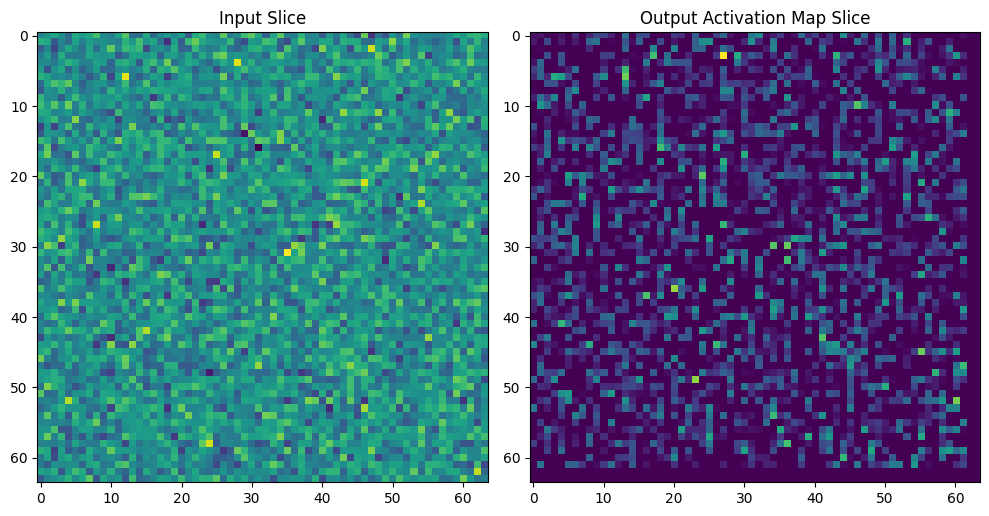

In [15]:
import matplotlib.pyplot as plt

# Visualize a slice of the input volume
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(input_volume[:, :, 0], cmap='viridis')
plt.title("Input Slice")

# Visualize a slice of the output volume
plt.subplot(122)
plt.imshow(output[0, :, :, 0], cmap='viridis')
plt.title("Output Activation Map Slice")

plt.tight_layout()
plt.show()


In [16]:
expected_output_shape = (
    num_filters,
    (input_volume.shape[0] - kernel_size[0] + 2 * padding) // stride + 1,
    (input_volume.shape[1] - kernel_size[1] + 2 * padding) // stride + 1,
    (input_volume.shape[2] - kernel_size[2] + 2 * padding) // stride + 1
)

print("Expected output shape:", expected_output_shape)
print("Actual output shape:", output.shape)
assert output.shape == expected_output_shape, "Output shape doesn't match expected shape"


Expected output shape: (32, 64, 64, 64)
Actual output shape: (32, 64, 64, 64)


Input Tensor Shape: (32, 64, 64, 64)
Max Pooled Output Shape: (32, 32, 32, 32)
Average Pooled Output Shape: (32, 32, 32, 32)


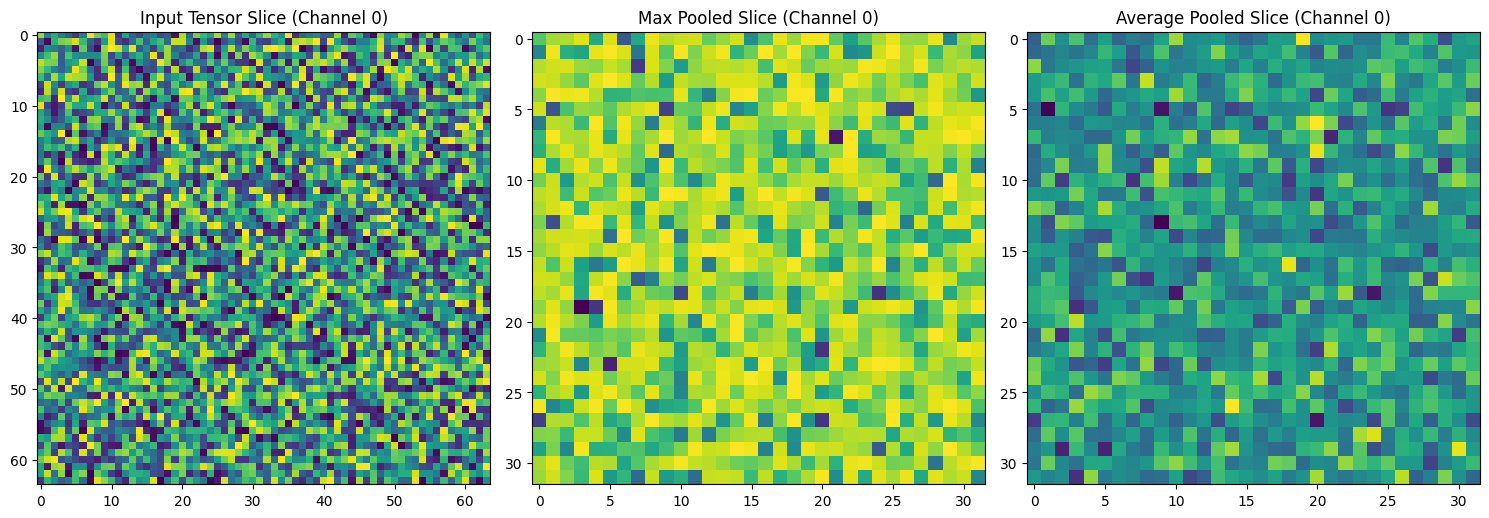

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pool3d(input_tensor, pool_size, stride, pooling_type='max'):
    c, d, h, w = input_tensor.shape
    p_d, p_h, p_w = pool_size
    s_d, s_h, s_w = stride

    # Calculate output dimensions
    out_d = (d - p_d) // s_d + 1
    out_h = (h - p_h) // s_h + 1
    out_w = (w - p_w) // s_w + 1

    # Initialize output tensor
    pooled_tensor = np.zeros((c, out_d, out_h, out_w))

    # Perform pooling
    for channel in range(c):
        for z in range(out_d):
            for y in range(out_h):
                for x in range(out_w):
                    # Extract the patch from the input tensor
                    patch = input_tensor[
                        channel,
                        z * s_d : z * s_d + p_d,
                        y * s_h : y * s_h + p_h,
                        x * s_w : x * s_w + p_w,
                    ]
                    if pooling_type == 'max':
                        pooled_tensor[channel, z, y, x] = np.max(patch)
                    elif pooling_type == 'average':
                        pooled_tensor[channel, z, y, x] = np.mean(patch)
                    else:
                        raise ValueError("Invalid pooling type. Use 'max' or 'average'.")

    return pooled_tensor

# Example usage
# Create a random 4D activation map (32 channels, depth=64, height=64, width=64)
input_tensor = np.random.rand(32, 64, 64, 64)

# Apply Max Pooling and Average Pooling
pool_size = (2, 2, 2)
stride = (2, 2, 2)

max_pooled_output = pool3d(input_tensor, pool_size=pool_size, stride=stride, pooling_type='max')
avg_pooled_output = pool3d(input_tensor, pool_size=pool_size, stride=stride, pooling_type='average')

print("Input Tensor Shape:", input_tensor.shape)
print("Max Pooled Output Shape:", max_pooled_output.shape)
print("Average Pooled Output Shape:", avg_pooled_output.shape)

# Verify dimensions
expected_output_shape = (
    input_tensor.shape[0],
    (input_tensor.shape[1] - pool_size[0]) // stride[0] + 1,
    (input_tensor.shape[2] - pool_size[1]) // stride[1] + 1,
    (input_tensor.shape[3] - pool_size[2]) // stride[2] + 1,
)
assert max_pooled_output.shape == expected_output_shape
assert avg_pooled_output.shape == expected_output_shape

# Visualization of a slice in depth dimension to compare pooling effects
channel_index = 0
slice_index = 0

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_tensor[channel_index, slice_index], cmap='viridis')
plt.title("Input Tensor Slice (Channel 0)")

plt.subplot(1, 3, 2)
plt.imshow(max_pooled_output[channel_index, slice_index], cmap='viridis')
plt.title("Max Pooled Slice (Channel 0)")

plt.subplot(1, 3, 3)
plt.imshow(avg_pooled_output[channel_index, slice_index], cmap='viridis')
plt.title("Average Pooled Slice (Channel 0)")

plt.tight_layout()
plt.show()
